In [ ]:
# 1. Tải bộ dữ liệu

!gdown 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

!unzip dataset.zip

In [2]:
# 2. Import các thư viện cần thiết

import torch # type: ignore
import torch.nn as nn # type: ignore

seed = 1
torch.manual_seed(seed)


import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore

from torch.utils.data import Dataset, DataLoader # type: ignore

In [8]:
# 3. Đọc bộ dữ liệu
dataset_filepat = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepat)

univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']

input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx+window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels


In [9]:
# 5. Chia bộ dữ liệu train, val, test
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
                                univariate_df,
                                df_start_idx=0,
                                df_end_idx=train_end_idx,
                                input_size=input_size,
                                label_size=label_size,
                                offset=offset
                                )

X_val, y_val = slicing_window(
                                univariate_df,
                                df_start_idx=train_end_idx,
                                df_end_idx=val_end_idx,
                                input_size=input_size,
                                label_size=label_size,
                                offset=offset
                                )

X_test, y_test = slicing_window(
                                univariate_df,
                                df_start_idx=val_end_idx,
                                df_end_idx=None,
                                input_size=input_size,
                                label_size=label_size,
                                offset=offset
                                )

In [16]:
# 5. Xây dựng pytorch datasets
class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y


# 6. Khai báo dataloader

train_dataset = WeatherForecast(X_train,y_train)
val_dataset = WeatherForecast(X_val,y_val)
test_dataset = WeatherForecast(X_test,y_test)

train_batch_size = 28
test_batch_size = 8

train_loader = DataLoader(
                        train_dataset,
                        batch_size=train_batch_size,
                        shuffle=True,
                        num_workers=1
                        )
val_loader = DataLoader(
                        val_dataset,
                        batch_size=test_batch_size,
                        shuffle=False,
                        num_workers=1
                        )
test_loader = DataLoader(
                        test_dataset,
                        batch_size=test_batch_size,
                        shuffle=False,
                        num_workers=1
                        )

# 7. Xây dựng mô hình
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = WeatherForecastor(
                            embedding_dim=embedding_dim,
                            hidden_size=hidden_size,
                            n_layers=n_layers,
                            dropout_prob=dropout_prob
                            )


# 8. Cài đặt hàm loss và optimizer
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00001)

EPOCH 1: 	Train loss: 45.5498 	Val loss: 2.2777 	Val acc: 0.0054
EPOCH 2: 	Train loss: 10.0624 	Val loss: 2.6636 	Val acc: 0.0054
EPOCH 3: 	Train loss: 9.0387 	Val loss: 1.7329 	Val acc: 0.0054
EPOCH 4: 	Train loss: 8.3842 	Val loss: 3.0877 	Val acc: 0.0054
EPOCH 5: 	Train loss: 7.8656 	Val loss: 1.7183 	Val acc: 0.0054
EPOCH 6: 	Train loss: 7.4549 	Val loss: 1.7851 	Val acc: 0.0054
EPOCH 7: 	Train loss: 7.1035 	Val loss: 2.0483 	Val acc: 0.0054
EPOCH 8: 	Train loss: 6.7086 	Val loss: 1.7444 	Val acc: 0.0054
EPOCH 9: 	Train loss: 6.4786 	Val loss: 1.6197 	Val acc: 0.0054
EPOCH 10: 	Train loss: 6.3067 	Val loss: 1.6037 	Val acc: 0.0054
EPOCH 11: 	Train loss: 6.1746 	Val loss: 1.5066 	Val acc: 0.0054
EPOCH 12: 	Train loss: 6.1186 	Val loss: 1.6213 	Val acc: 0.0054
EPOCH 13: 	Train loss: 5.9873 	Val loss: 2.1231 	Val acc: 0.0054
EPOCH 14: 	Train loss: 5.8717 	Val loss: 1.8340 	Val acc: 0.0054
EPOCH 15: 	Train loss: 5.8654 	Val loss: 1.7433 	Val acc: 0.0054
EPOCH 16: 	Train loss: 5.7481 	V

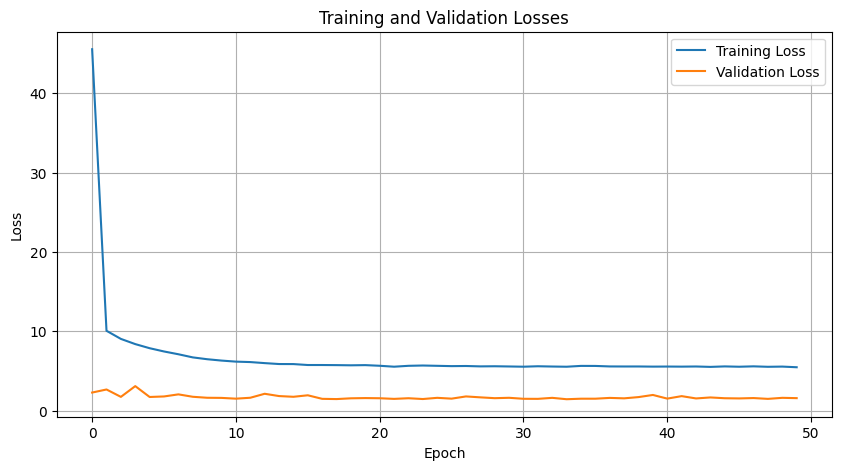

In [17]:
# 9. Thực hiện huấn luyện
def fit(model, train_loader, val_loader, criterion, optimizer, device, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_train_losses.append(loss.item())

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch+1}: \tTrain loss: {train_loss:.4f} \tVal loss: {val_loss:.4f} \tVal acc: {val_acc:.4f}')

    return train_losses, val_losses

def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# 10. Đánh giá mô hình
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print('Evaluation on val/test dataset')
print('Val accuracy', val_acc)
print('Test accuracy', test_acc)

Evaluation on val/test dataset
Val accuracy 0.005391394504924832
Test accuracy 0.006639692914202718


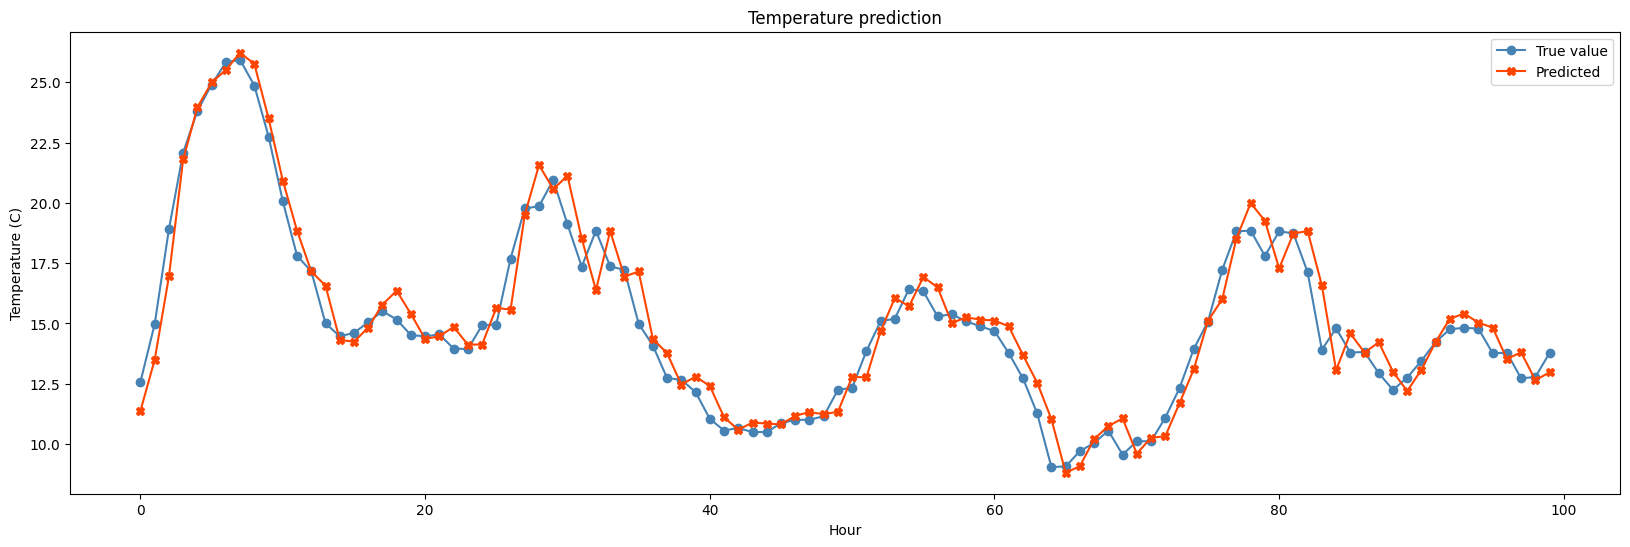

In [21]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Predicted')
    plt.title('Temperature prediction')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)